In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [3]:
#Importing the review data
df = pd.read_csv("C:/Users/Dell/Rohit/Sentiment_analysis_data/Reviews.csv")

# Data Source: https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/input

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df['Text'].values[1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In [6]:
df.shape

(568454, 10)

In [7]:
df = df.head(100)

In [8]:
df.shape

(100, 10)

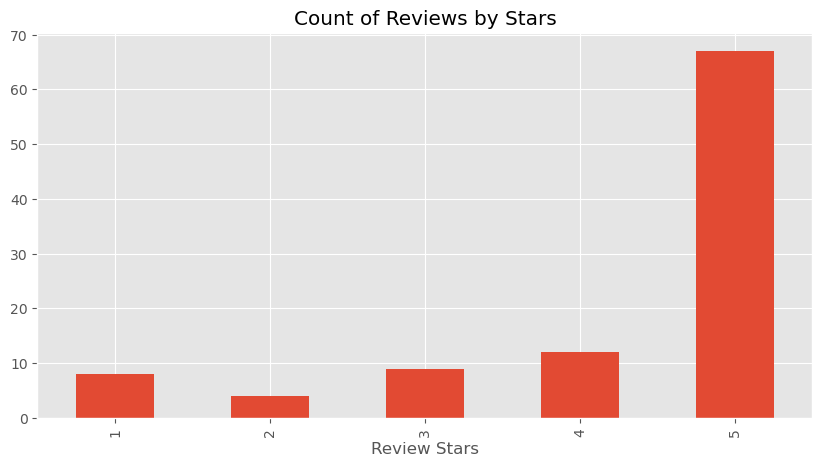

In [9]:
# Quick EDA

ax = df['Score'].value_counts().sort_index()  \
.plot(kind = 'bar', title = 'Count of Reviews by Stars', 
      figsize = (10,5))

ax.set_xlabel('Review Stars')
plt.show()
# df['Score'].value_counts().sort_index().plot(kind = 'line',color = 'blue', figsize = (10,5))

In [17]:
## Basic NLTK 
 # import nltk
 # nltk.download('punkt_tab')
ex = df['Text'][9]
print(ex)

This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [18]:
tokens = nltk.word_tokenize(ex)
tokens[:5]

['This', 'is', 'a', 'very', 'healthy']

In [19]:
tagged_tokens = nltk.pos_tag(tokens)
tagged_tokens[:5]

[('This', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('very', 'RB'), ('healthy', 'JJ')]

In [20]:
# import nltk
# nltk.download('maxent_ne_chunker_tab')

entities = nltk.chunk.ne_chunk(tagged_tokens)
entities.pprint()

(S
  This/DT
  is/VBZ
  a/DT
  very/RB
  healthy/JJ
  dog/NN
  food/NN
  ./.
  (PERSON Good/NNP)
  for/IN
  their/PRP$
  digestion/NN
  ./.
  Also/RB
  good/JJ
  for/IN
  small/JJ
  puppies/NNS
  ./.
  My/PRP$
  dog/NN
  eats/VBZ
  her/PRP$
  required/JJ
  amount/NN
  at/IN
  every/DT
  feeding/NN
  ./.)


In [21]:
## VADER Sentiment Approach

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [22]:
sia.polarity_scores(" I am happy. But, I am crying")

{'neg': 0.437, 'neu': 0.316, 'pos': 0.247, 'compound': -0.4215}

In [23]:
sia.polarity_scores("It is the worst thing happened to me.")

{'neg': 0.369, 'neu': 0.631, 'pos': 0.0, 'compound': -0.6249}

In [24]:
sia.polarity_scores(ex)

{'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.8313}

In [25]:
res = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
    text = row["Text"]
    myid = row["Id"]
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index': 'Id'})
vaders = vaders.merge(df, how = 'left')

In [27]:
vaders[:1]

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.0,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


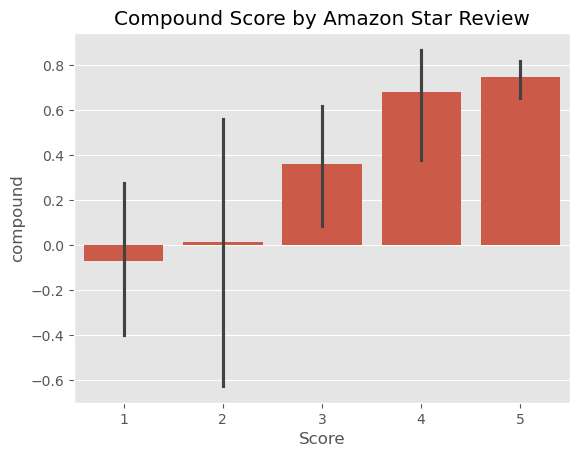

In [28]:
## Plotting vadersscores vs Ratings
ax = sns.barplot(data = vaders , x = "Score", y = 'compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()
                 

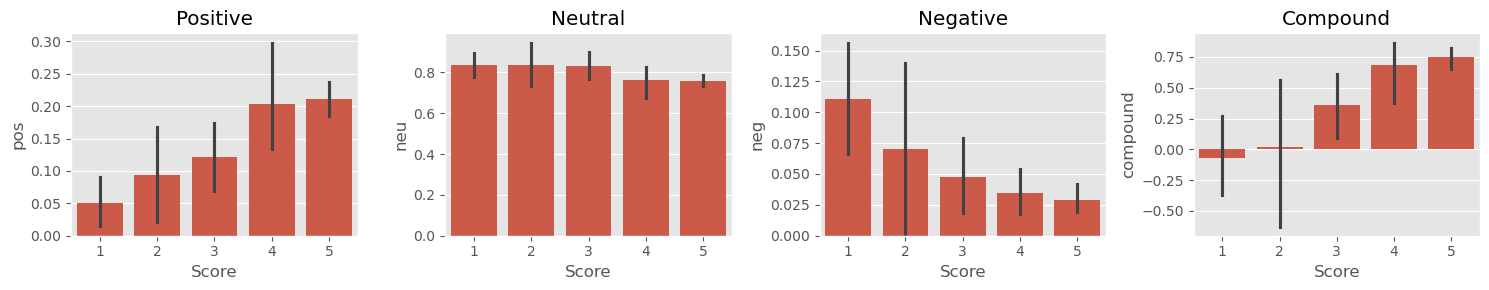

In [29]:
fig, axs = plt.subplots(1,4, figsize = (15,3))
sns.barplot(data = vaders, x = 'Score' , y = 'pos', ax = axs[0])
sns.barplot(data = vaders, x = 'Score' , y = 'neu', ax = axs[1])
sns.barplot(data = vaders, x = 'Score' , y = 'neg', ax = axs[2])
sns.barplot(data = vaders, x = 'Score' , y = 'compound', ax = axs[3])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
axs[3].set_title('Compound')
plt.tight_layout()
plt.show()


In [30]:
## Roberta Pretrained Model
# pip install transformers
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [31]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [33]:
# pip install torch torchvision torchaudio
# !pip install torch 

print(ex)
print(sia.polarity_scores(ex))

This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.
{'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.8313}


In [26]:
#Run for Roberta Model
encoded_text = tokenizer(ex, return_tensors = 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = { 
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)


{'roberta_neg': np.float32(0.019134082), 'roberta_neu': np.float32(0.0710444), 'roberta_pos': np.float32(0.9098215)}


In [37]:
# tokenizer(ex, return_tensors = 'pt')

In [38]:
def polarity_scores_roberta(ex):
    encoded_text = tokenizer(ex, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = { 
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict


In [43]:
res = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row["Text"]
        myid = row["Id"]
        vader_scores = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_scores.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_scores = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_scores}
        res[myid] = both

    except RuntimeError :  
        print(f"Broke for id {myid}")

  0%|          | 0/100 [00:00<?, ?it/s]

Broke for id 83


In [44]:
result_df = pd.DataFrame(res).T
result_df = result_df.reset_index().rename(columns = {'index': 'Id'})
result_df = result_df.merge(df, how = 'left')

In [45]:
result_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

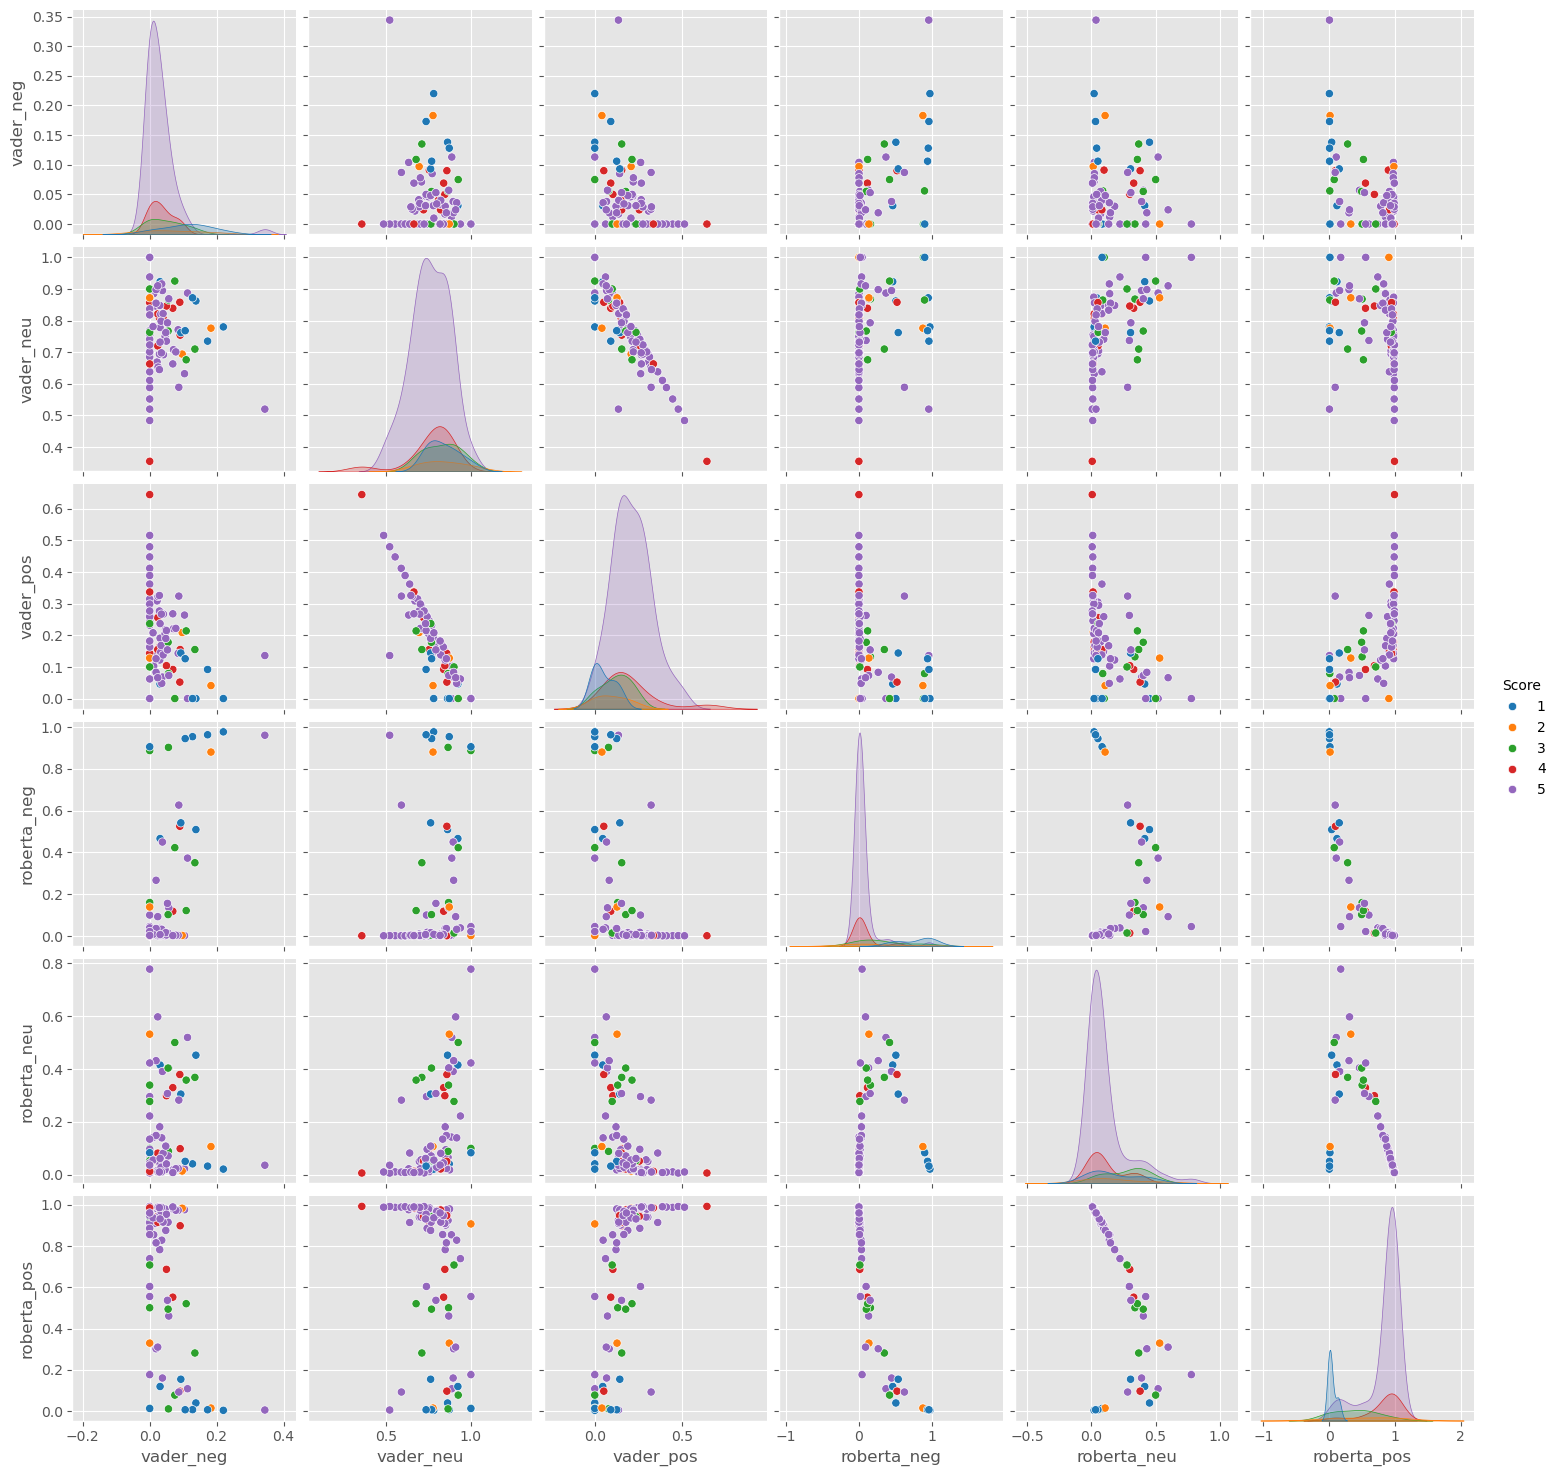

In [46]:
sns.pairplot(data = result_df , vars = ['vader_neg', 'vader_neu', 'vader_pos','roberta_neg', 'roberta_neu', 'roberta_pos'],
           hue = 'Score',
           palette = 'tab10')
plt.show()

In [47]:
result_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending = False)['Text'].values[0]

'Buyer Beware Please! This sweetener is not for everybody.  Maltitol is an alcohol sugar and can be undigestible in the body.  You will know a short time after consuming it if you are one of the unsuspecting many who cannot digest it by the extreme intestinal bloating and cramping and massive amounts of gas a person can experience. Nausea, diarrhea & headaches can also be experienced. I learned my lesson the hard way years ago when I fell in love with the sugar-free chocolates suzanne sommers used to sell.  I thought I\'d found sugar-free chocolate nirvana at first taste but the bliss was short lived when the terrible side effects of maltitol kicked in.  The discomfort was unlike anything I had ever felt before.  I blew up like a balloon and had very painful abdominal cramping.  As the symptoms passed, this too was very unpleasant.  Though hard for me to believe a low calorie sweetener could be the culprit, all symptoms were gone when I stopped eating the chocolate. My hunch it had som

In [48]:
result_df.query('Score == 1') \
    .sort_values('vader_pos', ascending = False)['Text'].values[0]

'Buyer Beware Please! This sweetener is not for everybody.  Maltitol is an alcohol sugar and can be undigestible in the body.  You will know a short time after consuming it if you are one of the unsuspecting many who cannot digest it by the extreme intestinal bloating and cramping and massive amounts of gas a person can experience. Nausea, diarrhea & headaches can also be experienced. I learned my lesson the hard way years ago when I fell in love with the sugar-free chocolates suzanne sommers used to sell.  I thought I\'d found sugar-free chocolate nirvana at first taste but the bliss was short lived when the terrible side effects of maltitol kicked in.  The discomfort was unlike anything I had ever felt before.  I blew up like a balloon and had very painful abdominal cramping.  As the symptoms passed, this too was very unpleasant.  Though hard for me to believe a low calorie sweetener could be the culprit, all symptoms were gone when I stopped eating the chocolate. My hunch it had som

In [49]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [50]:
sentiment_pipeline("I love you")

[{'label': 'POSITIVE', 'score': 0.9998656511306763}]

In [51]:
sentiment_pipeline("I will hit you")

[{'label': 'POSITIVE', 'score': 0.9997838139533997}]